In [1]:
import pandas as pd
import wfdb
import os
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, convolve
import matplotlib.pyplot as plt

In [2]:
ROOT_PATH = r"C:\Users\SGUZEY\Documents\Yüksek Lisans Dersleri\İleri Gömülü Sistemler\Data Sets\mit-bih-arrhythmia-database-1.0.0"

FS = 360

LOW_PASS_CUTOFF = 15.0
HIGH_PASS_CUTOFF = 5.0
BUTTER_ORDER = 4
DERIV_COEFFS = np.array([-1, -2, 0, 2, 1]) / 8.0 * FS
MWI_WINDOW_MS = 150
MWI_WINDOW_SAMPLES = int(MWI_WINDOW_MS * FS / 1000)
if MWI_WINDOW_SAMPLES < 1:
    MWI_WINDOW_SAMPLES = 1
MWI_KERNEL = np.ones(MWI_WINDOW_SAMPLES) / MWI_WINDOW_SAMPLES

In [3]:
INIT_WINDOW_SEC = 0.5
QRS_WINDOW_MS = 200
T_WAVE_WINDOW_MS = 360

ANALYSIS_SAMPLE_SIZE = 650000
PLOT_TIME_SEC = 10

OUTLIER_STD_FACTOR = 2.0
OUTLIER_WINDOW_SEC = 10
MAX_OUTLIER_PLOTS = 5

In [4]:
def load_records(root_path: str) -> list:
    original_records = []
    for root, dirs, files in os.walk(root_path):
        for f in files:
            if f.endswith('.hea'):
                rec_name = os.path.splitext(f)[0]
                if not rec_name.startswith('x_'):
                    original_records.append((rec_name, root))
    original_records = sorted(list(set(original_records)))
    print(f"Toplam {len(original_records)} adet orijinal kayıt bulundu.")
    return original_records

In [5]:
def load_and_merge_data(records: list) -> pd.DataFrame | None:
    all_data = []
    for rec, rec_path in records:
        try:
            record = wfdb.rdrecord(os.path.join(rec_path, rec))
            annotation = wfdb.rdann(os.path.join(rec_path, rec), 'atr')
            df = pd.DataFrame(record.p_signal, columns=record.sig_name)
            df['record'] = rec
            df['annotation'] = None
            for i, idx in enumerate(annotation.sample):
                if idx < len(df):
                    df.loc[idx, 'annotation'] = annotation.symbol[i]
            all_data.append(df)
        except Exception as e:
            print(f"{rec} okunamadı: {e}")

    if not all_data:
        print("Hiç veri yüklenemedi.")
        return None
    merged_df = pd.concat(all_data, ignore_index=True)
    print(f"Toplam örnek sayısı: {len(merged_df):,}")
    return merged_df

In [6]:
def _calculate_filter_coeffs(cutoff_freq: float, filter_type: str, fs: int = FS) -> tuple[np.ndarray, np.ndarray]:
    Nyquist = fs / 2
    normalized_cutoff = cutoff_freq / Nyquist
    b, a = butter(BUTTER_ORDER, normalized_cutoff, btype=filter_type, analog=False)
    return b, a

In [7]:
def apply_pan_tompkins_mwi_pipeline(ekg_signal_raw: np.ndarray, fs: int = FS) -> tuple:
    b_lpf, a_lpf = _calculate_filter_coeffs(LOW_PASS_CUTOFF, 'low', fs)
    ekg_lpf = filtfilt(b_lpf, a_lpf, ekg_signal_raw)
    b_hpf, a_hpf = _calculate_filter_coeffs(HIGH_PASS_CUTOFF, 'high', fs)
    ekg_bpf = filtfilt(b_hpf, a_hpf, ekg_lpf)
    ekg_deriv = convolve(ekg_bpf, DERIV_COEFFS, mode='same')
    ekg_squared = ekg_deriv ** 2
    ekg_mwi = convolve(ekg_squared, MWI_KERNEL, mode='same')
    return ekg_mwi, ekg_bpf, ekg_deriv, ekg_squared

In [8]:
def detect_peaks_adaptive_threshold(ekg_mwi: np.ndarray, fs: int = FS) -> tuple:
    INIT_WINDOW_SAMPLES = int(INIT_WINDOW_SEC * fs)
    QRS_WINDOW_SAMPLES = int(QRS_WINDOW_MS * fs / 1000)
    T_WAVE_WINDOW_SAMPLES = int(T_WAVE_WINDOW_MS * fs / 1000)

    max_initial_peak = np.max(ekg_mwi[:INIT_WINDOW_SAMPLES])
    SPKI = max_initial_peak * 0.9
    NPKI = np.mean(ekg_mwi[:INIT_WINDOW_SAMPLES]) * 0.5

    QRS_LOCS = []
    LAST_QRS_INDEX = 0
    N_total = len(ekg_mwi)
    SPKI_history = np.zeros(N_total)
    NPKI_history = np.zeros(N_total)
    TH1_history = np.zeros(N_total)

    peaks, _ = find_peaks(ekg_mwi, height=0, distance=QRS_WINDOW_SAMPLES // 2)
    peak_indices_set = set(peaks)

    for i in range(N_total):
        peak_val = ekg_mwi[i]
        TH1 = NPKI + 0.25 * (SPKI - NPKI)
        TH2 = 0.5 * TH1
        SPKI_history[i] = SPKI
        NPKI_history[i] = NPKI
        TH1_history[i] = TH1

        if i in peak_indices_set:
            is_refractory = (i - LAST_QRS_INDEX) < QRS_WINDOW_SAMPLES
            is_t_wave_range = (i - LAST_QRS_INDEX) < T_WAVE_WINDOW_SAMPLES
            if peak_val > TH1:
                if not is_refractory:
                    QRS_LOCS.append(i)
                    LAST_QRS_INDEX = i
                    SPKI = 0.125 * peak_val + 0.875 * SPKI
                else:
                    SPKI = 0.125 * peak_val + 0.875 * SPKI
            elif peak_val > TH2:
                if not is_t_wave_range and not is_refractory:
                    QRS_LOCS.append(i)
                    LAST_QRS_INDEX = i
                    SPKI = 0.25 * peak_val + 0.75 * SPKI
                elif is_t_wave_range:
                    NPKI = 0.125 * peak_val + 0.875 * NPKI
            else:
                NPKI = 0.125 * peak_val + 0.875 * NPKI

    QRS_LOCS = np.array(QRS_LOCS)
    return QRS_LOCS, SPKI_history, NPKI_history, TH1_history

In [9]:
def calculate_rr_stats(qrs_locs: np.ndarray, signal_length: int, fs: int = FS) -> tuple:
    """RR aralıklarını ve kalp hızı istatistiklerini hesaplar ve yazdırır."""
    qrs_locs_time = qrs_locs / fs
    rr_intervals = np.diff(qrs_locs_time)
    if len(rr_intervals) > 0:
        rr_mean, rr_std = np.mean(rr_intervals), np.std(rr_intervals)
        average_hr_bpm = 60 / rr_mean
    else:
        rr_mean, rr_std, average_hr_bpm = 0, 0, 0

    print(f"\n--- Detaylı Analiz İstatistikleri (Bölüm 1) ---")
    print(f"Tespit Edilen QRS Sayısı: {len(qrs_locs)}")
    print(f"Toplam Süre (saniye): {signal_length / fs:.2f}")
    print("\n--- RR Aralık İstatistikleri ---")
    print(f"Ortalama RR Aralığı (saniye): {rr_mean:.4f} s")
    print(f"RR Aralığı Standart Sapması (saniye): {rr_std:.4f} s")
    print("\n--- Kalp Atış Hızı Tahmini ---")
    print(f"Ortalama Kalp Atış Hızı (BPM): {average_hr_bpm:.2f} atım/dakika")
    return rr_intervals, rr_mean, rr_std, average_hr_bpm

In [10]:
def plot_processing_steps(plot_data: dict):
    t = plot_data['time']
    plt.figure(figsize=(15, 5))
    plt.plot(t, plot_data['raw'], 'b-', label='Ham EKG (MLII)')
    plt.title(f"1. Ham ECG Sinyali - İlk {PLOT_TIME_SEC} Saniye")
    plt.xlabel('Zaman (saniye)')
    plt.ylabel('Amplitüd')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(t, plot_data['filtered'], color='purple', label='Bant Geçiren Filtre Çıktısı')
    plt.title('2. Filtreleme (5-15 Hz Bandı)')
    plt.xlabel('Zaman (saniye)')
    plt.ylabel('Amplitüd')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(t, plot_data['deriv'], color='orange', label='Türevlenmiş Sinyal')
    plt.title('3. Türev Alma')
    plt.xlabel('Zaman (saniye)')
    plt.ylabel('Türev Amplitüdü')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(t, plot_data['squared'], 'g-', label='Karesi Alınmış Sinyal (Türev^2)')
    plt.title('4. Kare Alma Çıktısı')
    plt.xlabel('Zaman (saniye)')
    plt.ylabel('Kare Amplitüdü')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(t, plot_data['mwi'], color='red', label='MWI Çıktısı (QRS Enerjisi)')
    plt.title(f'5. Hareketli Pencere Bütünlemesi Çıktısı (Pencere: {MWI_WINDOW_MS}ms)')
    plt.xlabel('Zaman (saniye)')
    plt.ylabel('Enerji/Amplitüd')
    plt.legend();
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(t, plot_data['mwi'], 'b-', label='MWI Sinyali')
    plt.plot(t, plot_data['npki'], 'k--', label='Gürültü Seviyesi (NPKI)')
    plt.plot(t, plot_data['spki'], 'r--', label='Sinyal Seviyesi (SPKI)')
    plt.plot(t, plot_data['th1'], 'g--', label='Adaptif Eşik (TH1)')
    plt.scatter(plot_data['qrs_times'], plot_data['qrs_vals'], color='magenta', marker='*', s=80, zorder=5,
                label='Tespit Edilen QRS')
    plt.title('6. Adaptif Eşikleme ile QRS Tespiti')
    plt.xlabel('Zaman (saniye)')
    plt.ylabel('Amplitüd (MWI Çıktısı)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
def plot_rr_histogram(rr_intervals: np.ndarray, rr_mean: float, avg_hr_bpm: float):
    plt.figure(figsize=(10, 5))
    plt.hist(rr_intervals, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(rr_mean, color='red', linestyle='dashed', linewidth=2, label=f'Ortalama RR ({rr_mean:.4f} s)')
    plt.title(f'RR Aralıklarının Dağılımı (Ortalama Kalp Hızı: {avg_hr_bpm:.2f} BPM)')
    plt.xlabel('RR Aralığı (saniye)')
    plt.ylabel('Sayı')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_outliers(qrs_locs: np.ndarray, ekg_mwi: np.ndarray, rr_stats: tuple, fs: int = FS):
    rr_intervals, rr_mean, rr_std, _ = rr_stats
    lower_bound = rr_mean - OUTLIER_STD_FACTOR * rr_std
    upper_bound = rr_mean + OUTLIER_STD_FACTOR * rr_std
    outlier_rr_indices_qrs = np.where((rr_intervals < lower_bound) | (rr_intervals > upper_bound))[0] + 1
    outlier_qrs_locs = qrs_locs[outlier_rr_indices_qrs]
    regular_qrs_locs = np.array([loc for loc in qrs_locs if loc not in outlier_qrs_locs])

    print(f"\n--- Aykırı Değer Analizi (Bölüm 1) ---")
    print(f"Aykırı (Outlier) QRS Sayısı: {len(outlier_qrs_locs)}")
    HALF_WINDOW_SAMPLES = int(OUTLIER_WINDOW_SEC * fs / 2)
    if len(outlier_qrs_locs) == 0:
        print("\nTespit edilen aykırı QRS noktası bulunmamaktadır. Görselleştirme atlandı.")
        return

    outliers_to_plot = outlier_qrs_locs[:MAX_OUTLIER_PLOTS]
    num_plots = len(outliers_to_plot)
    print(
        f"\nTespit edilen aykırı QRS noktalarından ilk {num_plots} tanesi için {OUTLIER_WINDOW_SEC} saniyelik grafikler oluşturuluyor...")

    for i, outlier_loc in enumerate(outliers_to_plot):
        start_index = max(0, outlier_loc - HALF_WINDOW_SAMPLES)
        end_index = min(len(ekg_mwi), outlier_loc + HALF_WINDOW_SAMPLES)
        window_signal = ekg_mwi[start_index:end_index]
        window_time = np.arange(start_index, end_index) / fs
        center_time = outlier_loc / fs
        relative_time = window_time - center_time + (OUTLIER_WINDOW_SEC / 2)
        win_reg_qrs = regular_qrs_locs[(regular_qrs_locs >= start_index) & (regular_qrs_locs < end_index)]
        win_out_qrs = outlier_qrs_locs[(outlier_qrs_locs >= start_index) & (outlier_qrs_locs < end_index)]
        win_reg_times = win_reg_qrs / fs - center_time + (OUTLIER_WINDOW_SEC / 2)
        win_reg_vals = ekg_mwi[win_reg_qrs]
        win_out_times = win_out_qrs / fs - center_time + (OUTLIER_WINDOW_SEC / 2)
        win_out_vals = ekg_mwi[win_out_qrs]
        plt.figure(figsize=(15, 6))
        plt.plot(relative_time, window_signal, 'b-', label='MWI Sinyali')
        plt.scatter(win_reg_times, win_reg_vals, color='green', marker='o', s=50, zorder=5, label='Düzenli QRS')
        plt.scatter(win_out_times, win_out_vals, color='red', marker='X', s=100, zorder=6,
                    label='Aykırı QRS (Outlier)')
        plt.axvline(x=OUTLIER_WINDOW_SEC / 2, color='red', linestyle=':', alpha=0.6,
                    label=f'Aykırı Merkez Nokta ({OUTLIER_WINDOW_SEC / 2:.0f}s)')
        plt.title(f'Aykırı QRS Tespiti ({i + 1}/{num_plots}) - Merkez Zaman: {center_time:.2f} s')
        plt.xlabel(f'Göreceli Zaman (saniye) - Merkez Nokta t={OUTLIER_WINDOW_SEC / 2:.0f}s')
        plt.ylabel('Amplitüd (MWI Çıktısı)')
        plt.legend()
        plt.grid(True)
        plt.show()

In [13]:
def detect_peaks_simple(ekg_mwi: np.ndarray, fs: int = FS) -> np.ndarray:

    distance_samples = int(0.2 * fs)
    height_threshold = np.max(ekg_mwi) * 0.2
    peaks, _ = find_peaks(ekg_mwi, height=height_threshold, distance=distance_samples)
    return peaks

In [14]:
def create_feature_df(original_records: list, root_path: str, fs: int = FS) -> pd.DataFrame:

    all_features = []
    annotation_map = {'N': 'Normal', 'L': 'Normal', 'R': 'Normal', 'e': 'Normal', 'j': 'Normal',
                      'A': 'Supraventricular', 'a': 'Supraventricular', 'J': 'Supraventricular',
                      'S': 'Supraventricular', 'V': 'Ventricular', 'E': 'Ventricular', 'F': 'Fusion', '/': 'Paced',
                      'f': 'Fusion', 'Q': 'Unknown', '[': 'Start', '!': 'Unknown', ']': 'End', 'x': 'Unknown',
                      '(': 'Other', ')': 'Other', 'p': 'Other', 't': 'Other', 'u': 'Other', '`': 'Other', "'": 'Other',
                      '^': 'Other', '|': 'Other', '~': 'Other', '+': 'Other', 's': 'Supraventricular', 'D': 'Other',
                      '=': 'Other', '"': 'Other', '@': 'Other', 'B': 'Normal'}

    for rec_name, rec_path in original_records:
        try:
            record = wfdb.rdrecord(os.path.join(rec_path, rec_name))
            annotation = wfdb.rdann(os.path.join(rec_path, rec_name), 'atr')

            if 'MLII' in record.sig_name:
                signal_index = record.sig_name.index('MLII')
            elif 'V5' in record.sig_name:
                signal_index = record.sig_name.index('V5')
            else:
                print(f"Uyarı: {rec_name} MLII/V5 bulunamadı. Atlanıyor."); continue

            ekg_signal_raw = record.p_signal[:, signal_index]


            ekg_mwi, _, _, _ = apply_pan_tompkins_mwi_pipeline(ekg_signal_raw, fs)


            r_peak_indices_mwi = detect_peaks_simple(ekg_mwi, fs)

            r_peak_indices = []
            for mwi_peak_idx in r_peak_indices_mwi:
                search_window = int(0.05 * fs)
                start = max(0, mwi_peak_idx - search_window)
                end = min(len(ekg_signal_raw), mwi_peak_idx + search_window)
                window_raw = ekg_signal_raw[start:end]
                if len(window_raw) > 0:
                    r_peak_indices.append(start + np.argmax(window_raw))
                else:
                    r_peak_indices.append(mwi_peak_idx)

            r_peak_indices = np.array(r_peak_indices)
            if len(r_peak_indices) == 0: print(f"Uyarı: {rec_name} için R-tepesi bulunamadı."); continue

            r_peak_times = r_peak_indices / fs
            rr_post = np.diff(r_peak_times)
            rr_post = np.append(rr_post, rr_post[-1] if len(rr_post) > 0 else 0)
            rr_pre = np.diff(r_peak_times, prepend=r_peak_times[0] - (np.mean(rr_post) if len(rr_post) > 0 else 0.8))

            rr_local_mean = np.zeros_like(rr_pre)
            for i in range(len(rr_pre)): rr_local_mean[i] = np.mean(rr_pre[max(0, i - 4):i + 1])

            annotations_dict = dict(zip(annotation.sample, annotation.symbol))
            r_peak_annotations = []
            for r_idx in r_peak_indices:
                closest_ann_idx = annotation.sample[np.argmin(np.abs(annotation.sample - r_idx))]
                symbol = annotations_dict.get(closest_ann_idx, 'Q') if np.abs(closest_ann_idx - r_idx) <= int(
                    0.05 * fs) else 'Q'
                r_peak_annotations.append(symbol)

            for i, r_idx in enumerate(r_peak_indices):
                all_features.append({
                    'R_Peak_Index': r_idx, 'R_Peak_Time_s': r_peak_times[i],
                    'R_Peak_Amplitude_Raw': ekg_signal_raw[r_idx], 'R_Peak_Amplitude_MWI': ekg_mwi[r_idx],
                    'RR_Pre_s': rr_pre[i], 'RR_Post_s': rr_post[i], 'RR_Local_Mean_s': rr_local_mean[i],
                    'Annotation_Symbol': r_peak_annotations[i],
                    'Annotation_Category': annotation_map.get(r_peak_annotations[i], 'Unknown')
                })
        except Exception as e:
            print(f"Hata oluştu: {rec_name} işlenirken: {e}")

    return pd.DataFrame(all_features)

In [15]:
print("=" * 50)
print(" BÖLÜM 1: DETAYLI ANALİZ VE ÇİZİM BAŞLATILIYOR")
print("=" * 50)

original_records = load_records(ROOT_PATH)

merged_df = load_and_merge_data(original_records)

if merged_df is not None:
    print(merged_df.head())
else:
    print("Veri yüklenemedi, Bölüm 1 durduruldu.")

 BÖLÜM 1: DETAYLI ANALİZ VE ÇİZİM BAŞLATILIYOR
Toplam 48 adet orijinal kayıt bulundu.
Toplam örnek sayısı: 31,200,000
    MLII     V5 record annotation  V1  V2  V4
0 -0.145 -0.065    100       None NaN NaN NaN
1 -0.145 -0.065    100       None NaN NaN NaN
2 -0.145 -0.065    100       None NaN NaN NaN
3 -0.145 -0.065    100       None NaN NaN NaN
4 -0.145 -0.065    100       None NaN NaN NaN


In [16]:
if merged_df is not None:
    first_segment = merged_df.iloc[:ANALYSIS_SAMPLE_SIZE].copy()
    ekg_signal_raw = first_segment['MLII'].values
    N = len(ekg_signal_raw)
    signal_time = np.arange(N) / FS

    print(f"{N} örneklem (yaklaşık {N / FS:.2f} saniye) ham MLII sinyali analiz için hazırlandı.")

650000 örneklem (yaklaşık 1805.56 saniye) ham MLII sinyali analiz için hazırlandı.


In [17]:
if 'ekg_signal_raw' in locals():

    ekg_mwi, ekg_filtered, ekg_deriv, ekg_squared = \
        apply_pan_tompkins_mwi_pipeline(ekg_signal_raw, FS)

    print("Pan-Tompkins işleme adımları (Filtre, Türev, Kare, MWI) tamamlandı.")

Pan-Tompkins işleme adımları (Filtre, Türev, Kare, MWI) tamamlandı.


In [18]:
if 'ekg_mwi' in locals():

    qrs_locs, spki_history, npki_history, th1_history = \
        detect_peaks_adaptive_threshold(ekg_mwi, FS)

    print("Adaptif eşikleme (SPKI/NPKI) tamamlandı.")

Adaptif eşikleme (SPKI/NPKI) tamamlandı.


In [19]:
if 'qrs_locs' in locals():
    rr_stats = calculate_rr_stats(qrs_locs, N, FS)
    rr_intervals, rr_mean, rr_std, avg_hr_bpm = rr_stats


--- Detaylı Analiz İstatistikleri (Bölüm 1) ---
Tespit Edilen QRS Sayısı: 2273
Toplam Süre (saniye): 1805.56

--- RR Aralık İstatistikleri ---
Ortalama RR Aralığı (saniye): 0.7946 s
RR Aralığı Standart Sapması (saniye): 0.0502 s

--- Kalp Atış Hızı Tahmini ---
Ortalama Kalp Atış Hızı (BPM): 75.51 atım/dakika


In [20]:
if 'rr_stats' in locals():
    end_index = int(FS * PLOT_TIME_SEC)
    time_to_plot = signal_time[:end_index]

    qrs_in_plot_range_indices = qrs_locs[qrs_locs < end_index]
    qrs_in_plot_range_times = qrs_in_plot_range_indices / FS
    qrs_in_plot_range_vals = ekg_mwi[qrs_in_plot_range_indices]

    plot_data = {
        "time": time_to_plot,
        "raw": ekg_signal_raw[:end_index],
        "filtered": ekg_filtered[:end_index],
        "deriv": ekg_deriv[:end_index],
        "squared": ekg_squared[:end_index],
        "mwi": ekg_mwi[:end_index],
        "spki": spki_history[:end_index],
        "npki": npki_history[:end_index],
        "th1": th1_history[:end_index],
        "qrs_times": qrs_in_plot_range_times,
        "qrs_vals": qrs_in_plot_range_vals,
    }
    print(f"İlk {PLOT_TIME_SEC} saniyelik çizim verisi hazırlandı.")

İlk 10 saniyelik çizim verisi hazırlandı.


--- Grafik 1-6: Sinyal İşleme Adımları ---


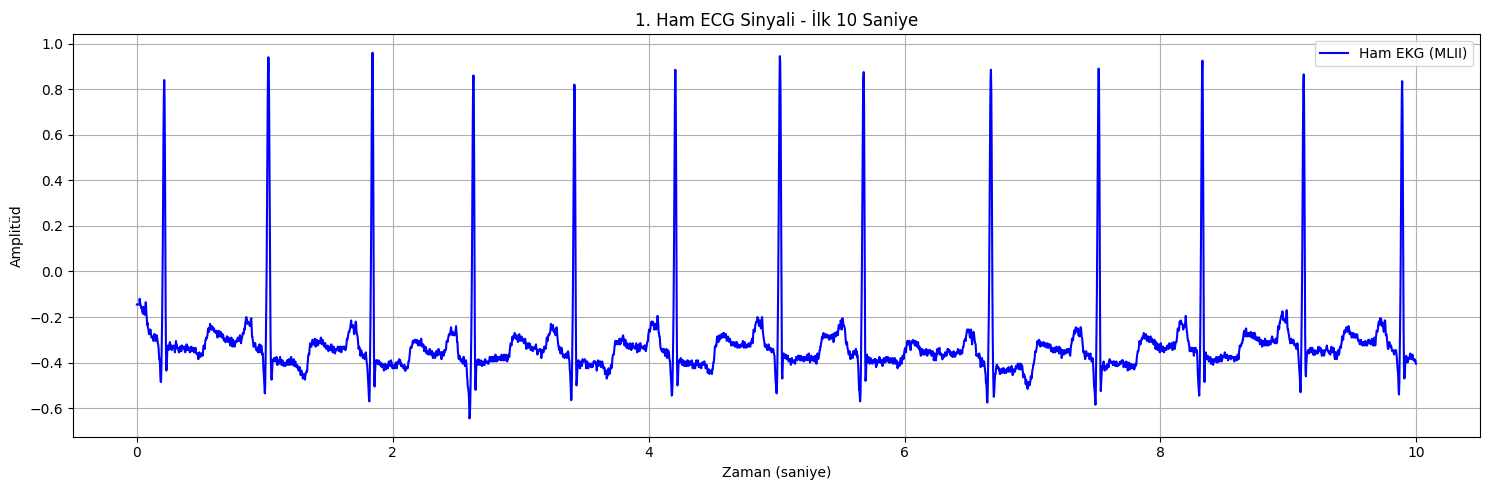

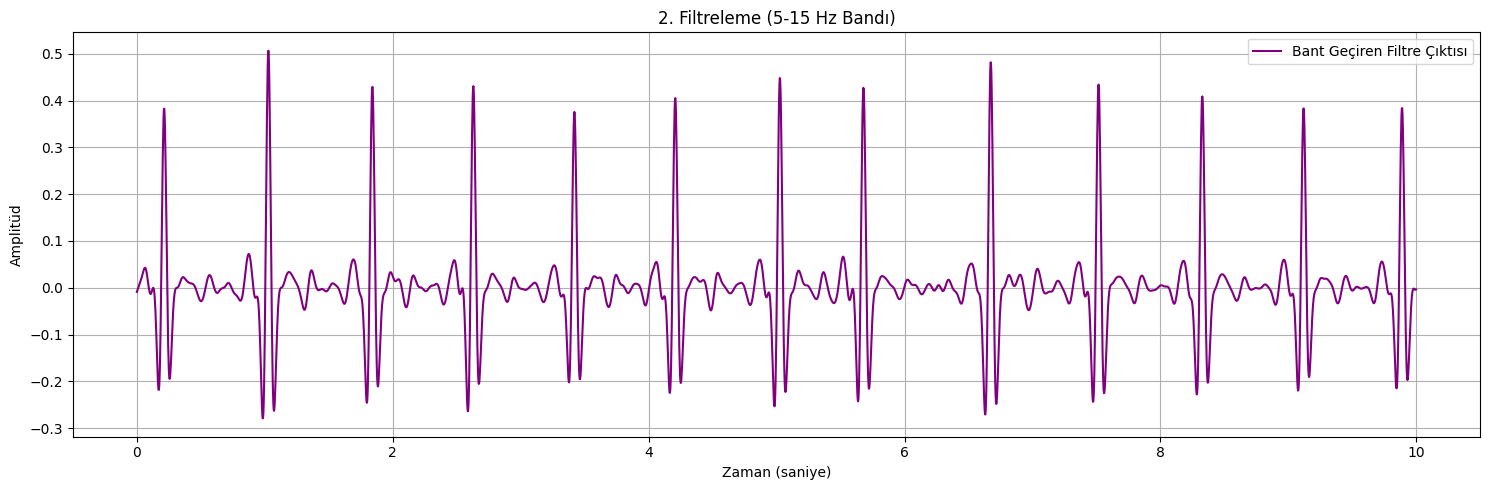

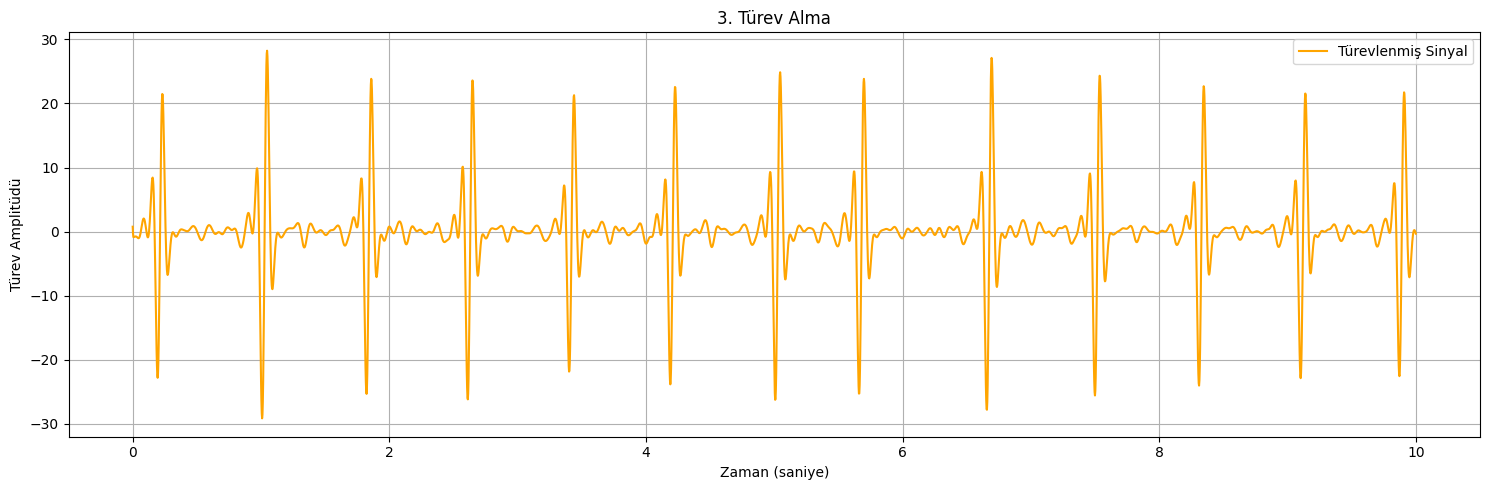

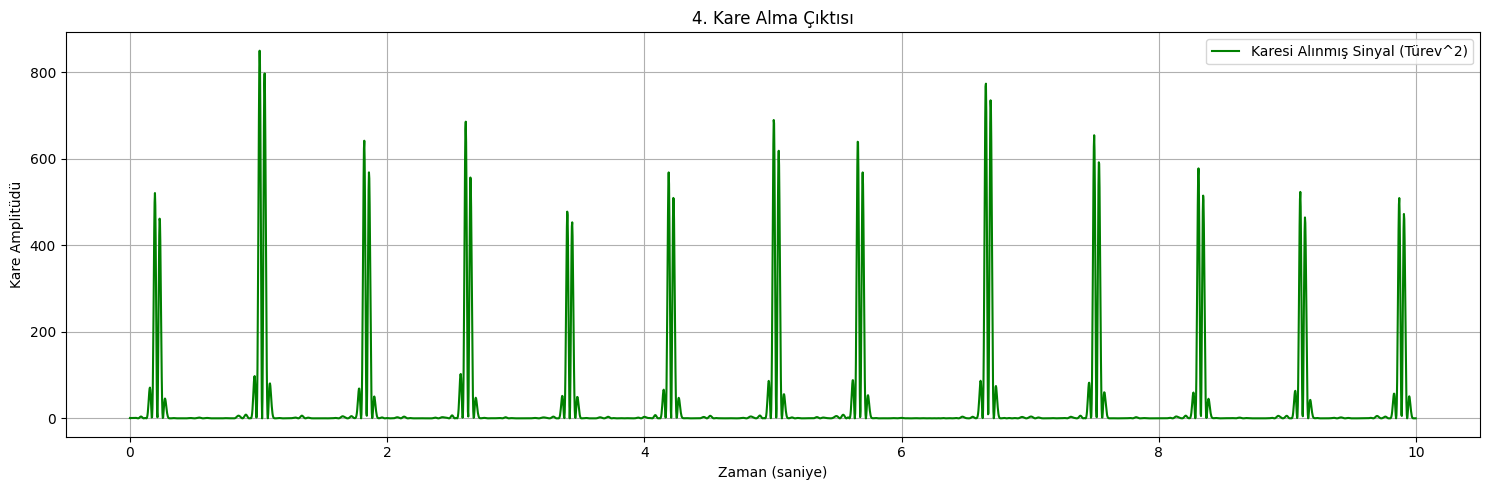

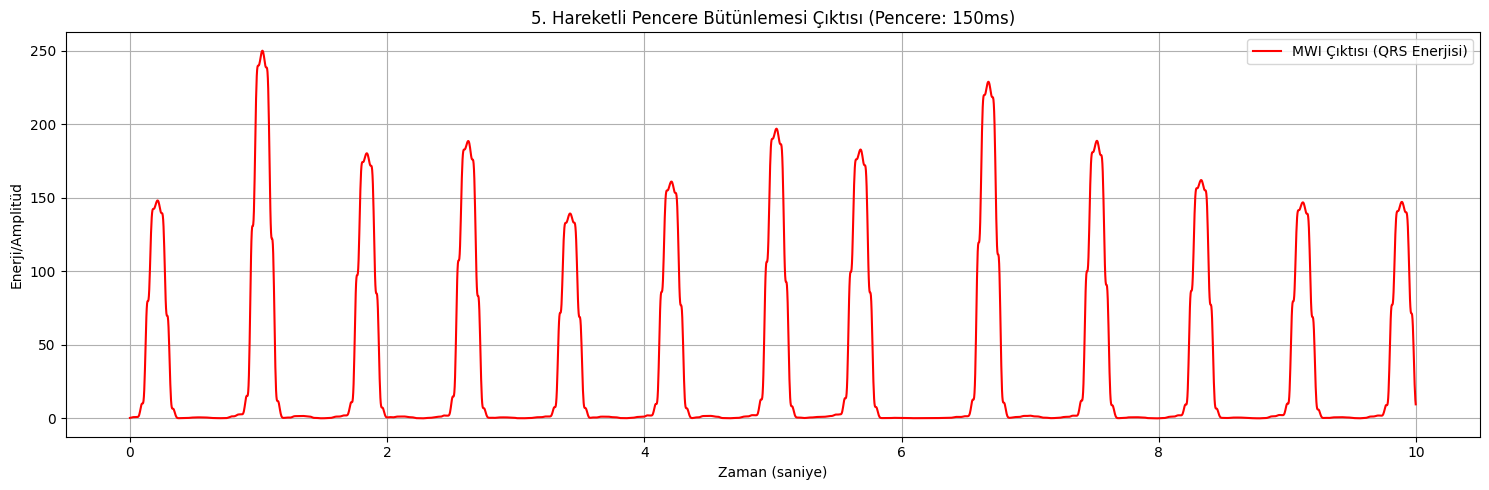

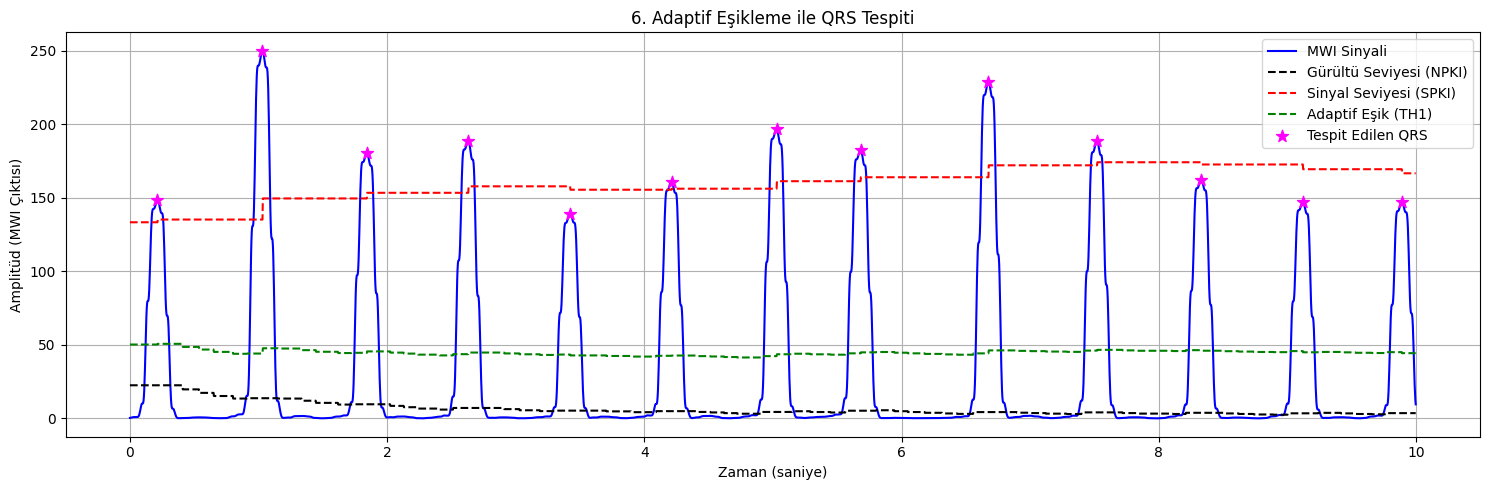


--- Grafik 7: RR Aralığı Dağılımı ---


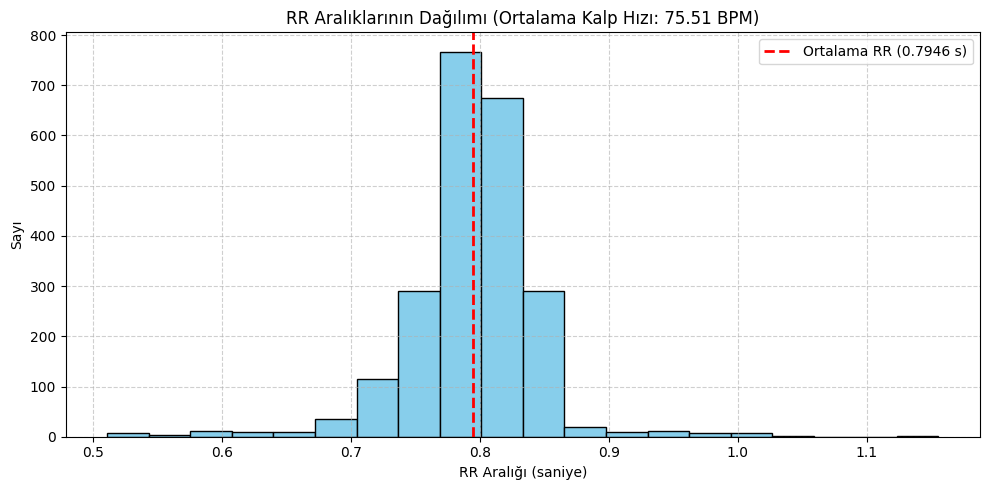


--- Grafik 8+: Aykırı QRS Tespiti ---

--- Aykırı Değer Analizi (Bölüm 1) ---
Aykırı (Outlier) QRS Sayısı: 97

Tespit edilen aykırı QRS noktalarından ilk 5 tanesi için 10 saniyelik grafikler oluşturuluyor...


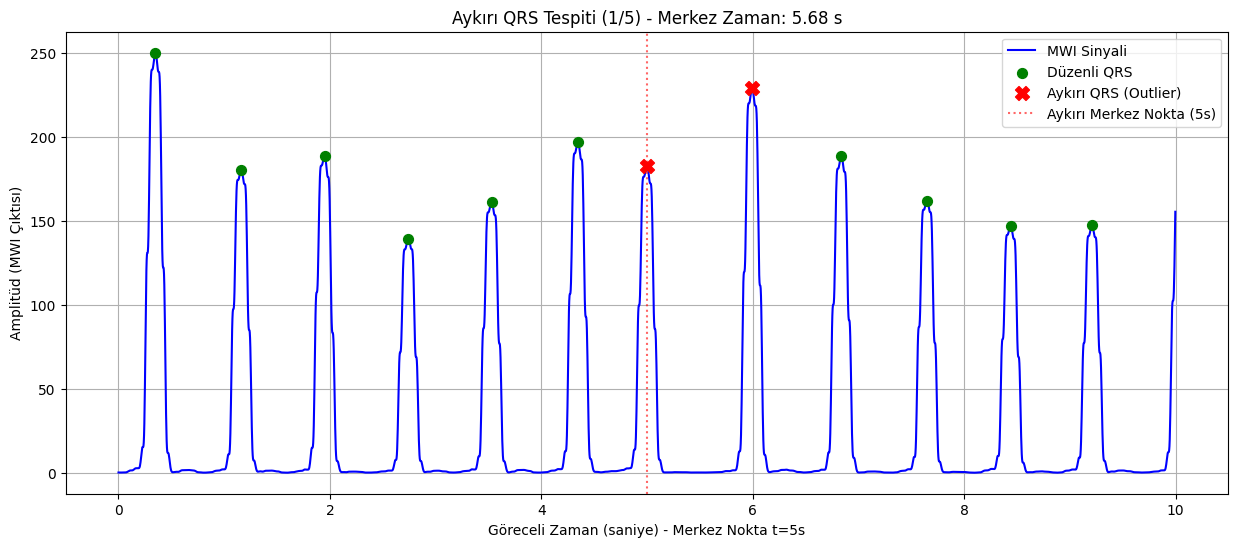

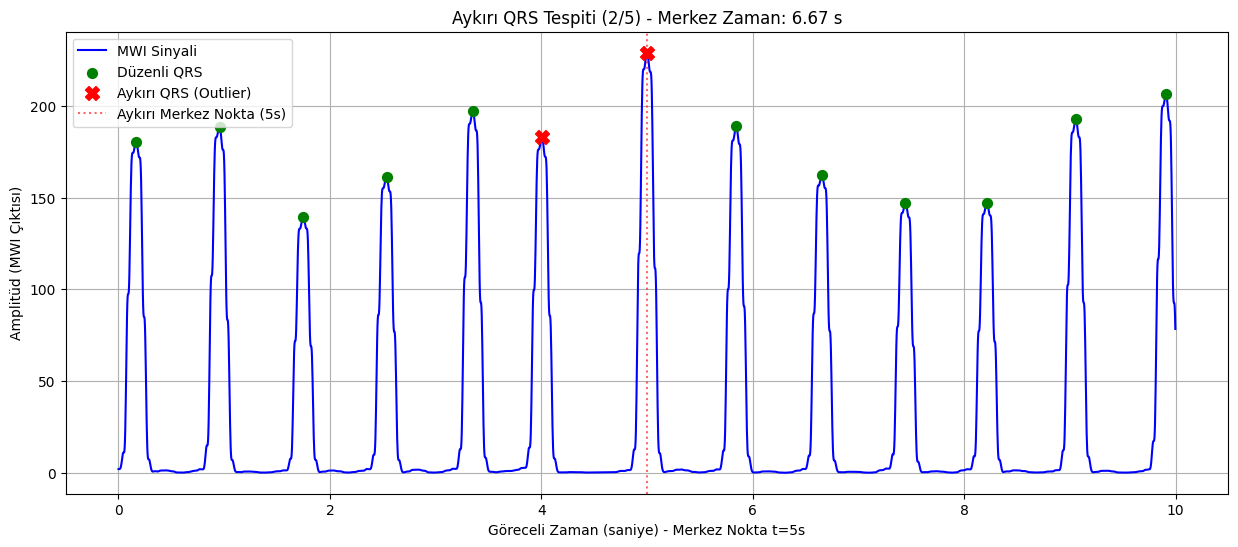

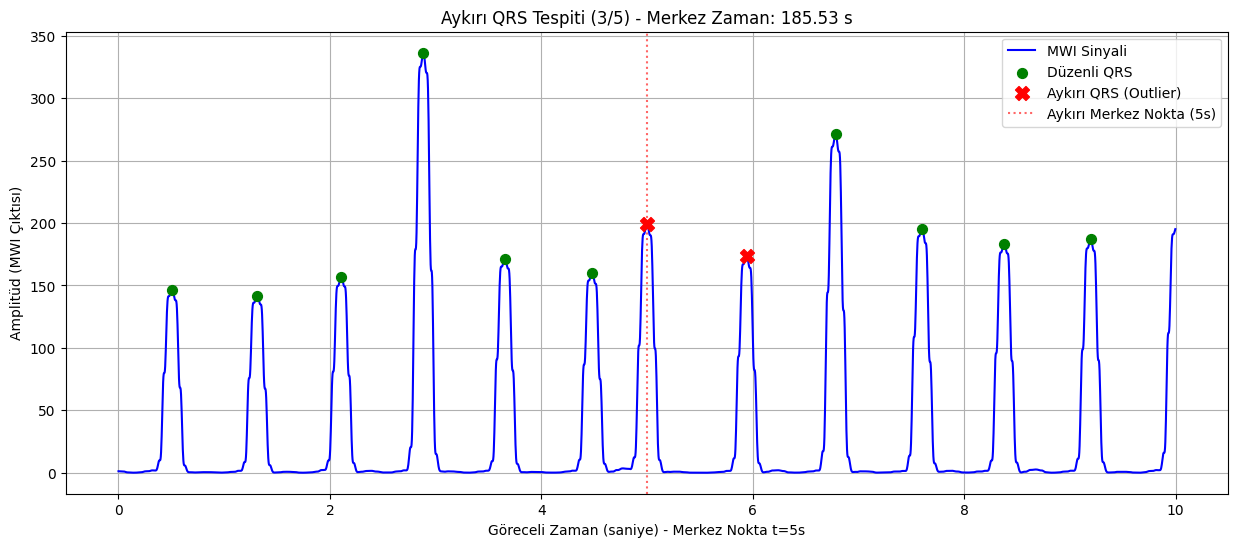

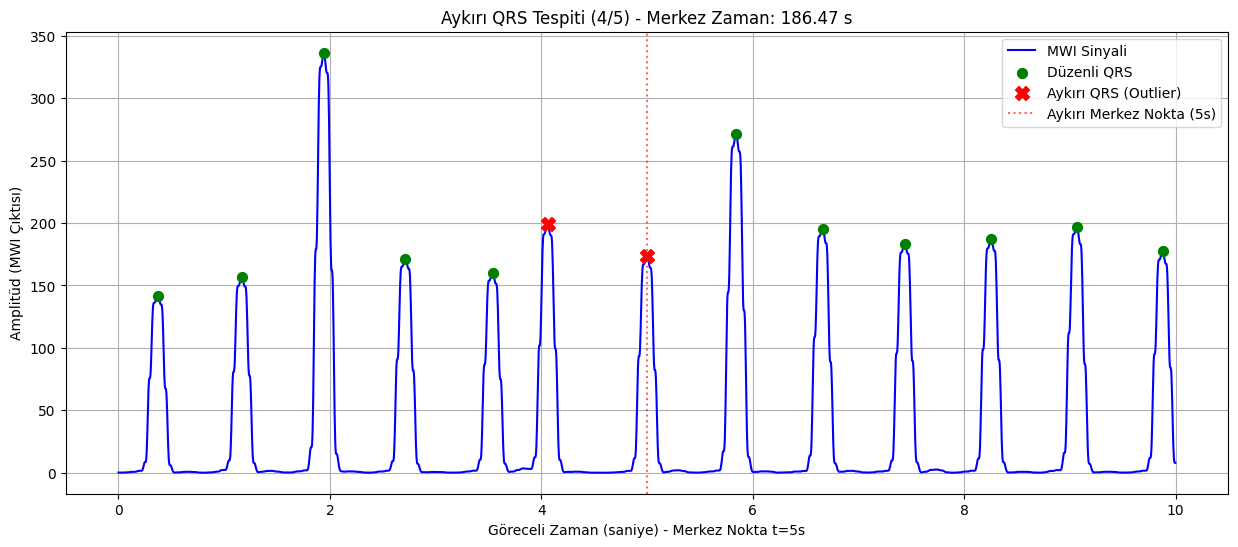

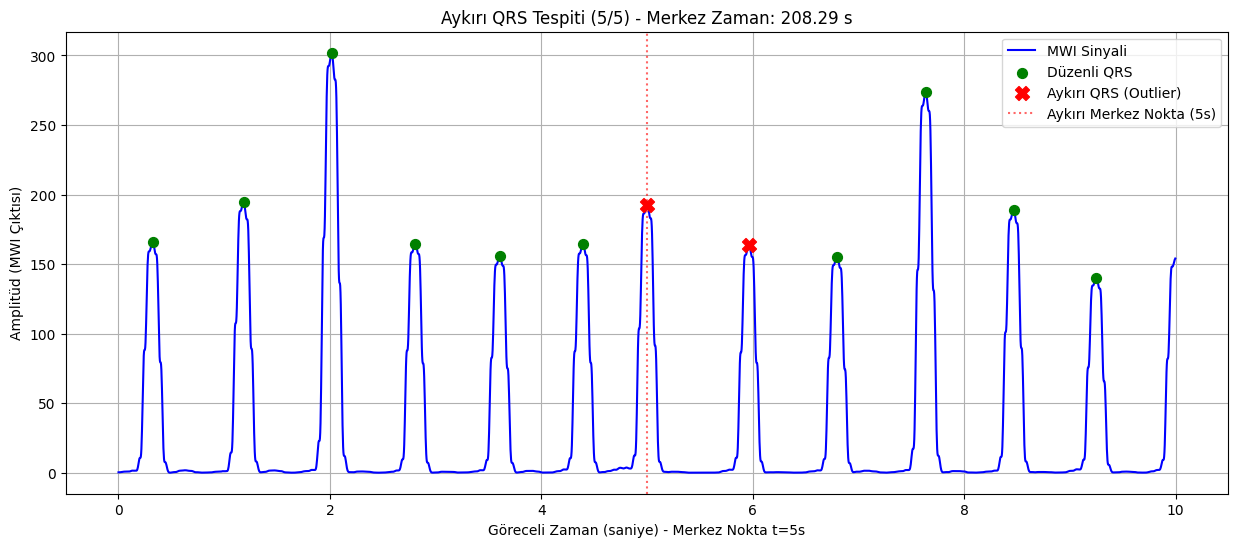


Bölüm 1 çizim işlemleri tamamlandı.


In [21]:
if 'plot_data' in locals():
    print("--- Grafik 1-6: Sinyal İşleme Adımları ---")
    plot_processing_steps(plot_data)

    print("\n--- Grafik 7: RR Aralığı Dağılımı ---")
    plot_rr_histogram(rr_intervals, rr_mean, avg_hr_bpm)

    print("\n--- Grafik 8+: Aykırı QRS Tespiti ---")
    plot_outliers(qrs_locs, ekg_mwi, rr_stats, FS)

    print("\nBölüm 1 çizim işlemleri tamamlandı.")

In [22]:
if 'original_records' not in locals():
    original_records = load_records(ROOT_PATH)

new_feature_df = create_feature_df(original_records, ROOT_PATH, FS)


 BÖLÜM 2: TÜM KAYITLARDAN ÖZELLİK ÇIKARIMI BAŞLATILIYOR


In [27]:
new_feature_df.head()

,R_Peak_Index,R_Peak_Time_s,R_Peak_Amplitude_Raw,R_Peak_Amplitude_MWI,RR_Pre_s,RR_Post_s,RR_Local_Mean_s,Annotation_Symbol,Annotation_Category
0,370,1.027778,0.940,249.961303,2.076579,14.622222,2.076579,N,Normal
1,5634,15.650000,0.970,302.296737,14.622222,4.886111,8.349400,N,Normal
2,7393,20.536111,1.050,338.957057,4.886111,2.369444,7.194971,N,Normal
3,8246,22.905556,0.955,250.899063,2.369444,3.294444,5.988589,N,Normal
4,9432,26.200000,1.045,321.521042,3.294444,3.219444,5.449760,N,Normal


In [28]:
new_feature_df['Annotation_Category'].value_counts()

Annotation_Category
Normal              73571
Ventricular          4615
Paced                4208
Supraventricular     2383
Unknown              1821
Fusion               1391
Other                  17
Name: count, dtype: int64

In [30]:
if 'new_feature_df' in locals():
    total_detections = len(new_feature_df)

    tp = len(new_feature_df[new_feature_df['Annotation_Category'] != 'Unknown'])

    fp = len(new_feature_df[new_feature_df['Annotation_Category'] == 'Unknown'])

    precision = 0.0
    if total_detections > 0:
        precision = tp / total_detections

    print(f"Algoritmanın Toplam Tespiti (TP + FP): {total_detections:,}")
    print(f"  -> Doğru Tespitler    (TP): {tp:,}")
    print(f"  -> Hatalı Tespitler   (FP): {fp:,}")
    print(f"\nBaşarım (Precision / P+): {precision * 100:.2f}%")
    print("(Anlamı: Algoritmanızın bulduğu her 100 R-tepesinden {:.2f} tanesi doğruydu.)".format(precision * 100))

else:
    print("Lütfen önce 'new_feature_df' oluşturmak için Hücre 10'u çalıştırın.")

Algoritmanın Toplam Tespiti (TP + FP): 88,006
  -> Doğru Tespitler    (TP): 86,185
  -> Hatalı Tespitler   (FP): 1,821

Başarım (Precision / P+): 97.93%
(Anlamı: Algoritmanızın bulduğu her 100 R-tepesinden 97.93 tanesi doğruydu.)
